In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
customer = pd.read_csv('Customer(fix).csv', delimiter=';')
transaction = pd.read_csv('Transaction(fix).csv', delimiter=';')

In [3]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      447 non-null    int64  
 1   Age             447 non-null    int64  
 2   Gender          447 non-null    object 
 3   Marital Status  447 non-null    object 
 4   Income          447 non-null    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 17.6+ KB


In [4]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB


In [5]:
# convert Date to datetime
transaction['Date'] = pd.to_datetime(transaction['Date'])



In [6]:
# merge df_transaction and df_customer
merged_df = pd.merge(transaction, customer, on='CustomerID', how='left')
merged_df.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,Female,Married,10.53
1,TR16356,165,2022-01-01,P9,10000,7,70000,1,44,Male,Married,14.58
2,TR1984,183,2022-01-01,P1,8800,4,35200,4,27,Male,Single,0.18
3,TR35256,160,2022-01-01,P1,8800,7,61600,4,48,Male,Married,12.57
4,TR41231,386,2022-01-01,P9,10000,1,10000,4,33,Female,Married,6.95


In [7]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   5020 non-null   object        
 1   CustomerID      5020 non-null   int64         
 2   Date            5020 non-null   datetime64[ns]
 3   ProductID       5020 non-null   object        
 4   Price           5020 non-null   int64         
 5   Qty             5020 non-null   int64         
 6   TotalAmount     5020 non-null   int64         
 7   StoreID         5020 non-null   int64         
 8   Age             5020 non-null   int64         
 9   Gender          5020 non-null   object        
 10  Marital Status  5020 non-null   object        
 11  Income          5020 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(6), object(4)
memory usage: 509.8+ KB


In [8]:
# aggregate data
agg = {
    'TransactionID': 'count',
    'Qty': 'sum',
    'TotalAmount': 'sum'
}
cluster_df = merged_df.groupby('CustomerID').aggregate(agg).reset_index()
cluster_df.head()


,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600


In [9]:
#Scaling data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(cluster_df[['TransactionID', 'Qty', 'TotalAmount']])
scaled_df = pd.DataFrame(scaled_df, columns=['TransactionID', 'Qty', 'TotalAmount'])
scaled_df.head()



,TransactionID,Qty,TotalAmount
0,1.779816,1.496527,2.094768
1,0.545884,1.261093,0.239269
2,1.162850,1.182615,0.672218
3,-0.379565,0.397833,-0.482047
4,-1.305014,-1.093251,-0.754347


Scaling data for clustering serves to ensure that the features used for clustering have similar scales. This is essential to prevent certain features from dominating the clustering process due to their larger scale, ensuring that all features contribute equally to the analysis. Scaling helps create a level playing field for the clustering algorithm, making it more effective and accurate in identifying meaningful patterns in the data.

### Inertia Method

In [10]:
# finding optimal number of clusters
inertia = []
max_clusters = 11
for n_cluster in range(1, max_clusters):
    kmeans = KMeans(n_clusters=n_cluster, random_state=123, n_init=n_cluster)
    kmeans.fit(cluster_df.drop('CustomerID', axis=1))
    inertia.append(kmeans.inertia_)

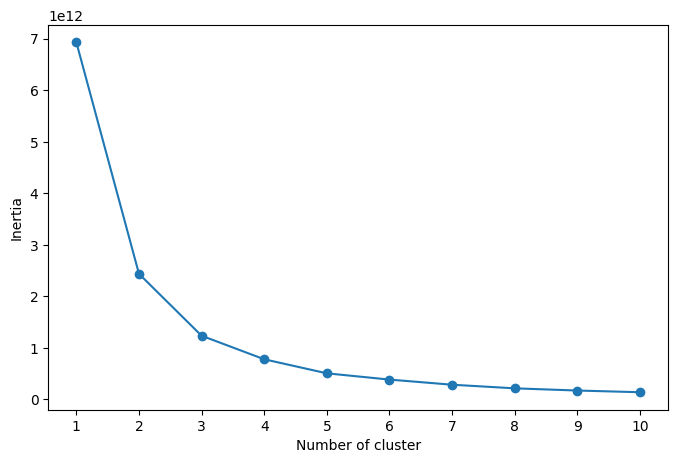

In [15]:
#Elbow Curve
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, max_clusters), inertia, marker='o')
plt.xlabel('Number of cluster')
plt.ylabel('Inertia')
plt.xticks(np.arange(1, max_clusters))
plt.show()



In the elbow curve, the point of the 'bend' formed on the plot is generally considered an indicator of the appropriate number of clusters. However, the 'optimal' value of 'k' obtained from the elbow curve method often tends to be somewhat "ambiguous" or not definitively conclusive in determining the optimal number of clusters ('k'). In the graph above, the choice of 'k' is set to 3 or 4 because the generated graph exhibits a bend and a subsequent leveling off. To ensure the chosen 'k' is indeed optimal, further analysis will be conducted using silhouette analysis.

### Silhouette Analysis Method

In [12]:
from sklearn.metrics import silhouette_score

# Silhouette Analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:

    # Initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=500)
    kmeans.fit(scaled_df)
    cluster_labels = kmeans.labels_

    # Silhouette Score
    silhouette_avg = silhouette_score(scaled_df, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))



For n_clusters=2, the silhouette score is 0.48530485981509097
For n_clusters=3, the silhouette score is 0.4286478086768933
For n_clusters=4, the silhouette score is 0.3772419295085858
For n_clusters=5, the silhouette score is 0.34207742281768294
For n_clusters=6, the silhouette score is 0.3002434408412865
For n_clusters=7, the silhouette score is 0.28136022927297194
For n_clusters=8, the silhouette score is 0.2917554906658225


Among the Silhouette Scores, n_clusters=2 had the highest score, indicating strong separation. However, the ambiguous elbow point led us to compare n_clusters=3 and n_clusters=4. n_clusters=3 had a respectable Silhouette Score, the highest after n_clusters=2, making it the optimal choice. Moreover, n_clusters=3 provides more diverse segmentation than n_clusters=2, allowing for a finer analysis of different data patterns and characteristics.

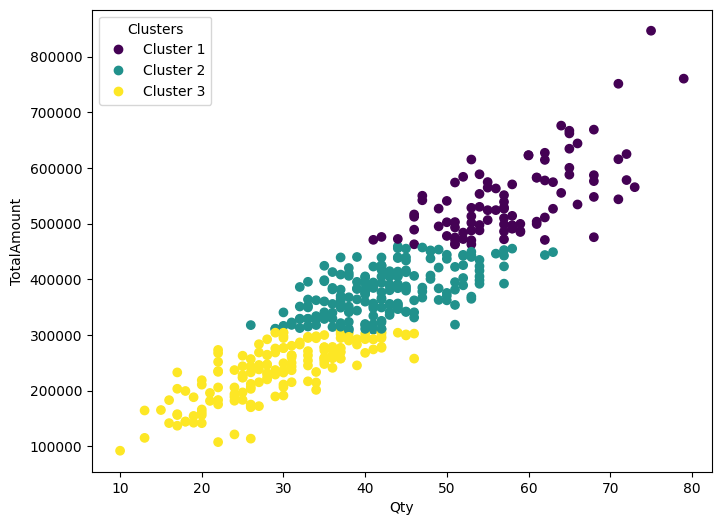

In [18]:
import matplotlib.pyplot as plt

# create cluster
n_cluster = 3
kmeans = KMeans(n_clusters=n_cluster, random_state=123, n_init=n_cluster)
kmeans.fit(cluster_df.drop('CustomerID', axis=1))
cluster_df['Cluster'] = kmeans.labels_

# plot cluster with a legend
plt.figure(figsize=(8, 6))
scatter = plt.scatter(cluster_df['Qty'], cluster_df['TotalAmount'], c=cluster_df['Cluster'], cmap='viridis')
plt.xlabel('Qty')
plt.ylabel('TotalAmount')

# Add a legend
legend_labels = [f'Cluster {i+1}' for i in range(n_cluster)]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Clusters')

plt.show()


SyntaxError: ignored